# **SARIMAX sur AirPassengers**

#####chargement des librairies

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
# Import de la librairie graphique Bokeh
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [ ]:
output_notebook()

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00


In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Libraries
# ======================================================================================
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version pdarima: {pmdarima.__version__}")
print(f"{color}Version statsmodels: {statsmodels.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.14.0
Version pdarima: 2.0.4
Version statsmodels: 0.14.4
Version pandas: 2.2.2
Version numpy: 1.26.4


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

print("Path to dataset files:", path)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

100%|██████████| 764/764 [00:00<00:00, 1.48MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rakannimer/air-passengers/versions/1


#####Lecture des données

In [ ]:
# from colab import file

from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
AirPass = pd.read_csv('AirPassengers.csv')
#AirPass = pd.read_csv('AirPassengers.csv', index_col='Month',parse_dates=True)

In [ ]:
AirPass.head()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
AirPass['Month'] = pd.to_datetime(AirPass['Month'], format="%Y-%m", errors="coerce" )

In [ ]:
AirPass.set_index('Month', inplace=True)

In [ ]:
AirPass.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
from bokeh.models import HoverTool


# Création d'une source de données de colonne
source = ColumnDataSource(AirPass)

# Création d'un nouveau graphique
p = figure(x_axis_type="datetime", title="Données des passagers aériens")

# Ajout d'un traceur de ligne
ligne = p.line(x='Month', y='Passengers', line_width=2, source=source)

# Ajout des hover tools
hover = HoverTool(renderers=[ligne], tooltips=[("Mois", "@Month{%F}")
                                               , ("Passengers", "@Passengers")]
                                               , formatters={"@Month": "datetime"}
                 )

p.add_tools(hover)

# Affichage du graphique
show(p)


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# Sélectionner la dernière décénnie et réaliser un résumé statistique: moyenne, écart-type, min, max.

# Selecting the last decade
last_decade = AirPass.tail(120)  # Assuming 10 years * 12 months/year

# Statistical summary
summary_stats = last_decade['Passengers'].describe()
summary_stats

,Passengers
count,120.000000
mean,309.725000
std,109.525406
min,145.000000
25%,224.750000
50%,303.500000
75%,390.250000
max,622.000000


##### Agréger par mois et représenter graphiquement (en Bokeh sur toute la série)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

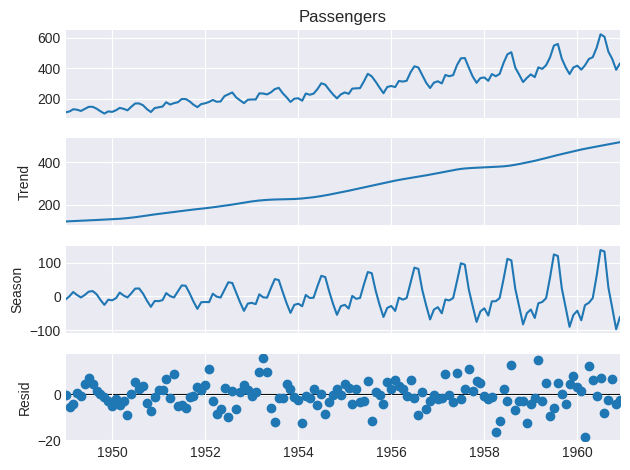

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Appliquer la décomposition STL
stl = STL(AirPass['Passengers'], seasonal=13)  # Période saisonnière réglée sur 13 (données mensuelles)
resultat = stl.fit()

# Tracer la décomposition
fig = resultat.plot()

# Afficher le graphique
plt.show()

In [ ]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

stat, p = shapiro(resultat.resid)

print("Statistics=%.3f, p=%.3f" % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print("Echantillon gaussien (non reject H0)")
else:
    print("Echantillon non gaussien (rejet H0)")

Statistics=0.990, p=0.426
Echantillon gaussien (non reject H0)


#####Test de stationnarité

In [ ]:
print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(AirPass['Passengers'])
kpss_result = kpss(AirPass['Passengers'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Interprétation
alpha = 0.05
if adfuller_result[1] > alpha:
    print("La série n'est pas stationnaire (non-rejet de H0).")
else:
    print("La série est stationnaire (rejet de H0).")

Test stationarity for original series
-------------------------------------
ADF Statistic: 0.8153688792060498, p-value: 0.991880243437641
KPSS Statistic: 1.6513122354165206, p-value: 0.01
La série n'est pas stationnaire (non-rejet de H0).


<ipython-input-17-b499ce0c420b>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(AirPass['Passengers'])


In [ ]:
import numpy as np
data = np.log(AirPass['Passengers'])

#####Differenciation d'ordre 1

In [ ]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data.diff().dropna()

In [ ]:
print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data_diff_1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


# Interprétation
alpha = 0.05
if adfuller_result[1] > alpha:
    print("La série n'est pas stationnaire (non-rejet de H0).")
else:
    print("La série est stationnaire (rejet de H0).")


Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -2.717130598388114, p-value: 0.07112054815086184
KPSS Statistic: 0.03830446954674065, p-value: 0.1
La série n'est pas stationnaire (non-rejet de H0).


#####Differenciation d'ordre 2

In [ ]:
data_diff_2 = data_diff_1.diff().dropna()

In [ ]:
print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data_diff_2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


# Interprétation
alpha = 0.05
if adfuller_result[1] > alpha:
    print("La série n'est pas stationnaire (non-rejet de H0).")
else:
    print("La série est stationnaire (rejet de H0).")


Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -8.19662913218224, p-value: 7.419304549376186e-13
KPSS Statistic: 0.059624316402332886, p-value: 0.1
La série est stationnaire (rejet de H0).


#####Auto correlation

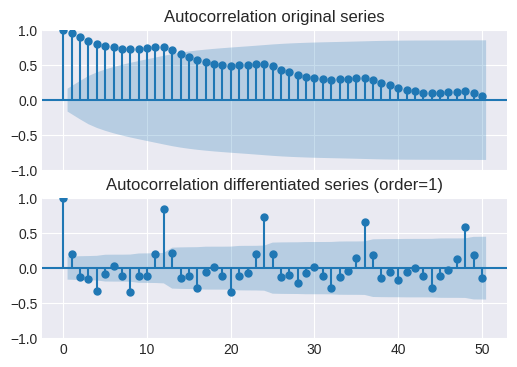

In [ ]:
# Autocorrelation plot for original and differentiated series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)');

#####Partial autocorrelation

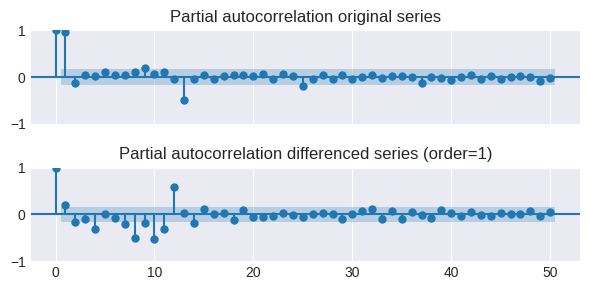

In [ ]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

In [ ]:
# First-order differentiation combined with seasonal differentiation
# ==============================================================================

data_diff_1_12 = data.diff().diff(12).dropna()

adfuller_result = adfuller(data_diff_1_12)
kpss_result = kpss(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Interprétation
alpha = 0.05
if adfuller_result[1] > alpha:
    print("La série n'est pas stationnaire (non-rejet de H0).")
else:
    print("La série est stationnaire (rejet de H0).")

ADF Statistic: -4.4433249418311425, p-value: 0.00024859123113838495
KPSS Statistic: 0.07319096983125449, p-value: 0.1
La série est stationnaire (rejet de H0).


#####Split data to data-train and data-test

In [ ]:
from datetime import datetime,timedelta
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

data_train=AirPass[:train_dataset_end]
data_test=AirPass[train_dataset_end+timedelta(days=1):test_dataset_end]

# Vérifier les tailles
print("Taille des données d'entraînement :", len(data_train))
print("Taille des données de test :", len(data_test))

Taille des données d'entraînement : 84
Taille des données de test : 60


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


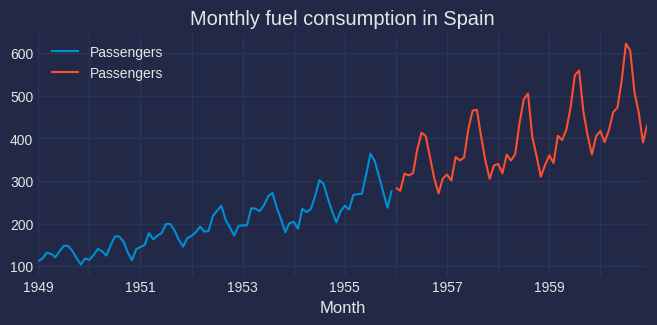

In [ ]:
set_dark_theme()
# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

#####Modele SARIMAX

SARIMAX(data_train, order=(p, d, q),seasonal_order=(P, D, Q, s)

In [ ]:
from pmdarima import auto_arima

# Auto ARIMA
model = auto_arima(data_train, seasonal=True, m=12, trace=True, suppress_warnings=True)
print("Best SARIMAX parameters:", model.order, "Seasonal:", model.seasonal_order)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=542.053, Time=3.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=597.376, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=536.684, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=560.740, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=696.878, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=540.380, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=538.290, Time=0.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=538.461, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=536.644, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=538.298, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=539.788, Time=1.81 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=589.655, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=537.805, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=538.008, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=538.754, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12]             : AIC=543.645, Time=0.21 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12] intercept
Total fit time: 10.283 seconds
Best SARIMAX parameters: (1, 0, 0) Seasonal: (0, 1, 1, 12)


In [ ]:
# Sarimax Model
# ==============================================================================

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(data_train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
results = model.fit()
results.summary()
warnings.filterwarnings("default")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Prediction
# ==============================================================================
pred_Sarima=results.predict(start=datetime(1955,12,1),end=datetime(1960,12,1))
residuals=data_test['Passengers']-pred_Sarima

<Axes: >

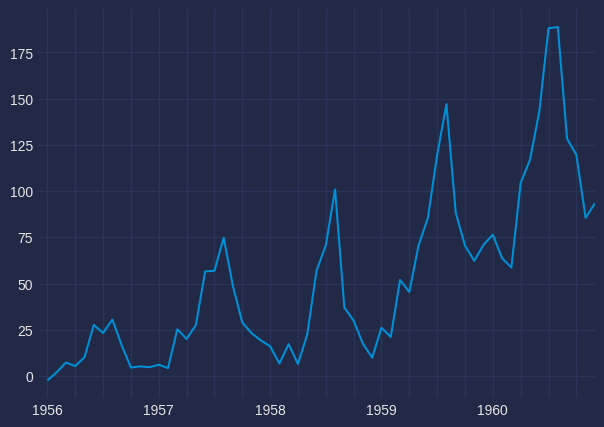

In [ ]:
residuals.plot()

In [ ]:
forecast = results.get_forecast(steps=len(data_test))

In [ ]:
forecast_values = forecast.predicted_mean

In [ ]:
# Calculer l'erreur de prédiction (RMSE)
from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(data_test['Passengers'], forecast_values))
print("RMSE: {:.3f}".format(rmse))

RMSE: 70.095


In [ ]:
data_test['Predicted_SARIMA']=pred_Sarima

<ipython-input-106-62d367da5e55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Predicted_SARIMA']=pred_Sarima


<Axes: xlabel='Month'>

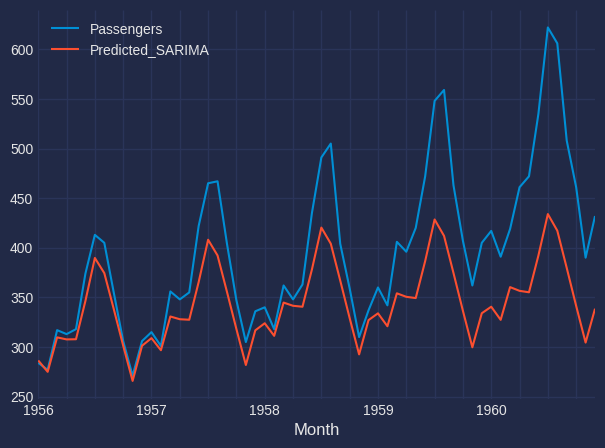

In [ ]:
data_test[['Passengers','Predicted_SARIMA']].plot()